In [1]:
!pip install labelme opencv-python albumentations

  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-win_amd64.whl (38.1 MB)


- labelme allows to do annotations
- tensorflow for Deep Learning
- matplotlib for rendering images
- albumentations for data augmentations by Bounding Box Augmentations

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

Collect Images

In [4]:
capture = cv2.VideoCapture(0)
#time.sleep(3)
for imgnum in range(number_images):
    print('Collecting Image - '.format(imgnum))
    ret, frame = capture.read()
    if not ret:
        print('Error capturing video frame')
        break
    imgname=os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame',frame)
    time.sleep(2)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
capture.release()
cv2.destroyAllWindows()

In [5]:
#image shape - dimensionalities
print(frame.shape)

(480, 640, 3)


In [8]:
!labelme

Analyze Datasets 

In [10]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [11]:
# limit the gpu memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.config.list_physical_devices('GPU')

[]

In [14]:
# load images into TF Data Pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [15]:
images.as_numpy_iterator().next()

b'data\\images\\000bb4d5-eb1e-11ed-af06-30d16be1dbf8.jpg'

In [16]:
# Image loading
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [18]:
images = images.map(load_images)

In [19]:
images.as_numpy_iterator().next()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 72,  76,  51],
        [ 71,  76,  44],
        [ 71,  77,  43]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 72,  76,  51],
        [ 72,  77,  47],
        [ 72,  78,  44]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 73,  77,  54],
        [ 73,  77,  50],
        [ 73,  78,  46]],

       ...,

       [[  7,  10,   3],
        [  6,   9,   2],
        [  6,   9,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  5,   7,   2],
        [  5,   7,   2],
        [  5,   7,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  5,   7,   2],
        [  6,   8,   3],
        [  6,   8,   3],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

<b>Visualize Images</b>

In [20]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

In [22]:
plot_images = image_generator.next()

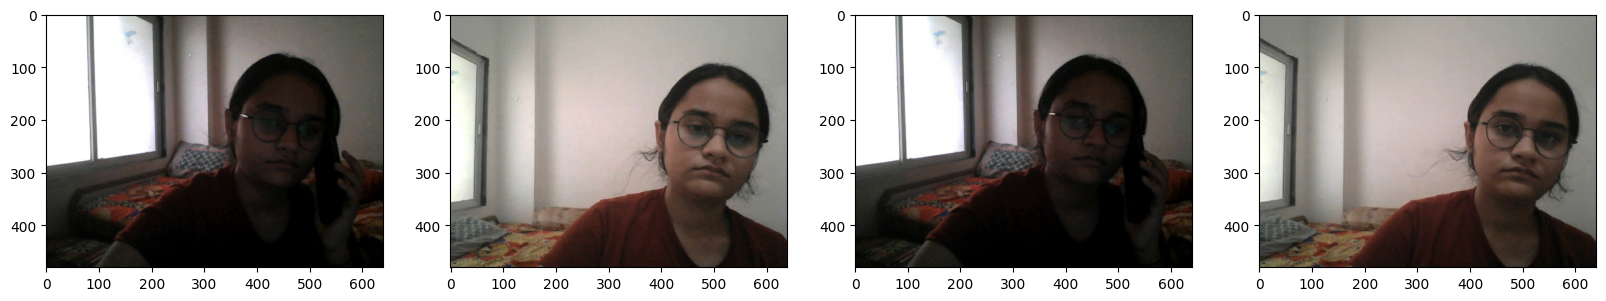

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

running above cell will iterate throughout the images. <br>
i.e, Will get next images at every iteration.

<b>Partition Unaugmented Data</b><br>
MANUAL PROCESS to split data to training, testing and validation

In [31]:
print("Train Data - ",120*0.7)
print("Test Data - ",120*0.15) #18 test 18 val

Train Data -  84.0
Test Data -  18.0


In [33]:
# moving their labels to the directories
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

<b>Image Augmentations on Images and Labels using Albumentations</b>

In [34]:
import albumentations as alb

Different formats for BboxParams - 
- albumentations
- pascal_voc
- coco
- yolo

In [37]:
# Applying 6 augmentations
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)],
                        bbox_params = alb.BboxParams(format='albumentations', label_fields =['class_labels']))

Load Test image and annote it with OpenCV and JSON

In [38]:
img = cv2.imread(os.path.join('data','train','images','ed0c8258-eb13-11ed-9192-30d16be1dbf8.jpg'))
img #returns none that means it is not in train folder else return image value 

In [40]:
img = cv2.imread(os.path.join('data','train','images','01420ee7-eb1e-11ed-9c0b-30d16be1dbf8.jpg'))
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 58,  75,  72],
        [ 58,  75,  72],
        [ 58,  75,  72]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 61,  75,  73],
        [ 60,  74,  72],
        [ 60,  74,  72]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 62,  75,  73],
        [ 62,  75,  73],
        [ 61,  74,  72]],

       ...,

       [[ 10,   9,   5],
        [ 10,   9,   5],
        [  7,   8,   4],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  7,   9,   3],
        [  7,   9,   3],
        [  7,   8,   4],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  8,  10,   4],
        [  7,   9,   3],
        [  7,   8,   4],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [41]:
with open(os.path.join('data','train','labels','01420ee7-eb1e-11ed-9c0b-30d16be1dbf8.json'),'r') as f:
    label = json.load(f)

In [45]:
# for the above img
print(type(label))
print(label['shapes'])
print(label['shapes'][0]['label'])
label 

<class 'dict'>
[{'label': 'face', 'points': [[331.986301369863, 71.50684931506848], [560.068493150685, 335.2054794520548]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}}]
face


{'version': '5.2.0.post4',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[331.986301369863, 71.50684931506848],
    [560.068493150685, 335.2054794520548]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\01420ee7-eb1e-11ed-9c0b-30d16be1dbf8.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcY

- Extract Coordinates and rescale to Match Image Resolution